In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import pickle
import scipy

## Load and combine raw data from all three batches

In [2]:
batch1 = pickle.load(open(r'../Data/batch1.pkl', 'rb'))
#remove batteries that do not reach 80% capacity
del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

In [3]:
numBat1 = len(batch1.keys())
numBat1

41

In [4]:
batch2 = pickle.load(open(r'../Data/batch2.pkl','rb'))

In [5]:
# There are four cells from batch1 that carried into batch2, we'll remove the data from batch2
# and put it with the correct cell from batch1
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482];

In [6]:
for i, bk in enumerate(batch1_keys):
    batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
    for j in batch1[bk]['summary'].keys():
        if j == 'cycle':
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
        else:
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
    last_cycle = len(batch1[bk]['cycles'].keys())
    for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
        batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]

In [7]:
del batch2['b2c7']
del batch2['b2c8']
del batch2['b2c9']
del batch2['b2c15']
del batch2['b2c16']

In [8]:
numBat2 = len(batch2.keys())
numBat2

43

In [9]:
batch3 = pickle.load(open(r'../Data/batch3.pkl','rb'))
# remove noisy channels from batch3
del batch3['b3c37']
del batch3['b3c2']
del batch3['b3c23']
del batch3['b3c32']
del batch3['b3c42']
del batch3['b3c43']

In [10]:
numBat3 = len(batch3.keys())
numBat3

40

In [11]:
numBat = numBat1 + numBat2 + numBat3
numBat

124

In [12]:
bat_dict = {**batch1, **batch2, **batch3}

In [262]:
def crop_data(id,cycle):
    # isolate discharging data
    cropped = np.array([[Q, V] for Q, V, I in zip(bat_dict[id]["cycles"][cycle]["Qd"], bat_dict[id]["cycles"][cycle]["V"], bat_dict[id]["cycles"][cycle]["I"]) if I < -0.001])
    for i, datapoint in enumerate(cropped):
        if datapoint[1] < cropped[i+1, 1]:
            if datapoint[1] < 2.2: # identify where discharging ends
                end = i+1
                break
            # else: # this is an anomalous increase in voltage; remove so voltage is decreasing
            #     cropped[i+1, 1] = cropped[i, 1]
    cropped = cropped[:end]    
    x = np.flip(cropped[:, 1])
    y = np.flip(cropped[:, 0])
    return x,y

In [263]:
from scipy.interpolate import RBFInterpolator

def get_Qd_resampled(cycle, id):
    x_list, y_list = crop_data(cycle, id)
    interpolated = RBFInterpolator(x_list[::3, np.newaxis], y_list[::3], degree=1)
    x_new = np.linspace(2.0, 3.59, 1000)[:, np.newaxis]
    return interpolated(x_new)

In [264]:
def get_var(id):
    y_100_resampled = get_Qd_resampled(id, "100")
    y_10_resampled = get_Qd_resampled(id, "10")
    # print(np.var(y_100_resampled - y_10_resampled))
    return np.log10(np.var(y_100_resampled - y_10_resampled))

In [265]:
var_dict = []
for id in bat_dict.keys():
    if id[1] in ["2", "3"]: var_dict.append([get_var(id),np.log10(bat_dict[id]["cycle_life"])[0][0]])
    else: var_dict.append([get_var(id),np.log10(bat_dict[id]["cycle_life"])])
var_dict = np.array(var_dict)

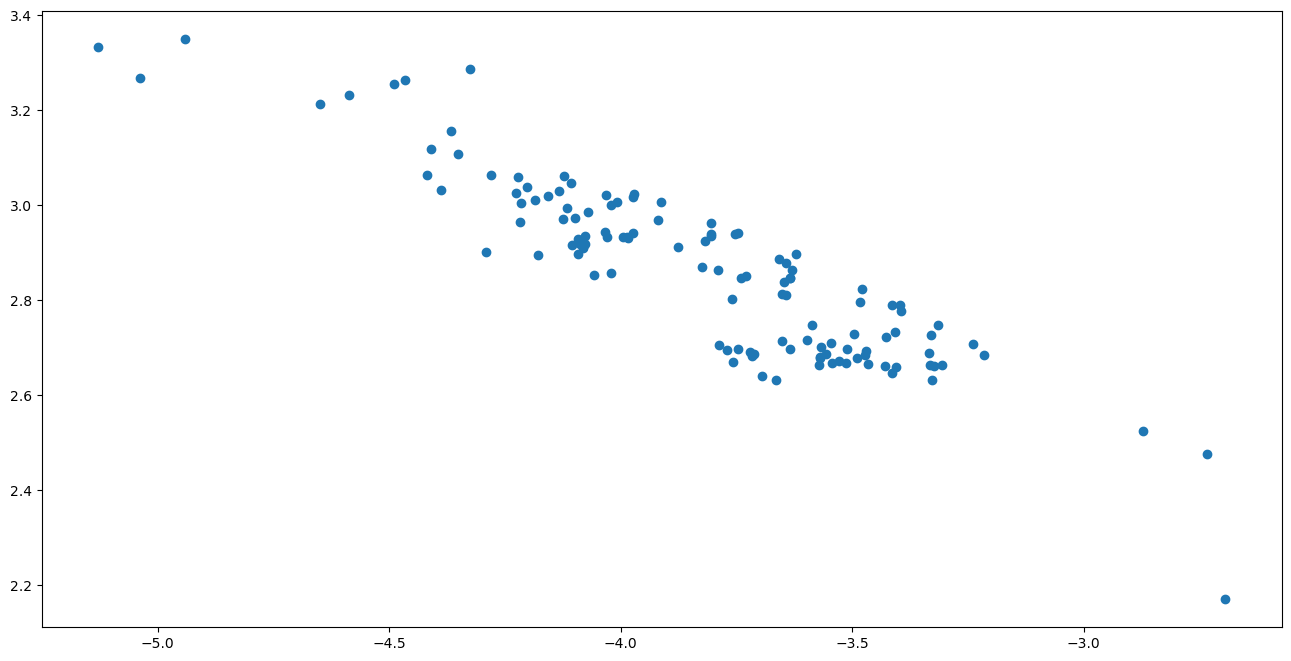

In [266]:
plt.scatter(var_dict[:,0],var_dict[:,1])
#plt.xlim(left=-6,right=-2)
#plt.ylim(top=3.5,bottom=2)